In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from yellowbrick.cluster import KElbowVisualizer
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler, QuantileTransformer
from sklearn.decomposition import PCA
from yellowbrick.cluster import SilhouetteVisualizer
from sklearn.metrics import silhouette_score, davies_bouldin_score, adjusted_rand_score
from kmodes.kprototypes import KPrototypes
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as pp
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import scipy.cluster.hierarchy as sch
from scipy.cluster.hierarchy import dendrogram
from sklearn.model_selection import GridSearchCV

In [3]:
%load_ext pycodestyle_magic
%flake8_on

In [5]:
data = pd.read_csv('data_RFM_Avis.csv')
data = data.drop_duplicates(subset = 'customer_unique_id')
data = data.fillna(data.median())
data.set_index("customer_unique_id", inplace=True)

/var/folders/75/b2_qxv4d42z5lmd3n5965zhr0000gn/T/ipykernel_23480/887186569.py:3: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  data = data.fillna(data.median())
2:35: E251 unexpected spaces around keyword / parameter equals
2:37: E251 unexpected spaces around keyword / parameter equals


In [6]:
data

,Recency,Frequency,MonetaryValue,review_score
customer_unique_id,,,,
0000366f3b9a7992bf8c76cfdf3221e2,161,1,141.90,5.0
0000b849f77a49e4a4ce2b2a4ca5be3f,164,1,27.19,4.0
0000f46a3911fa3c0805444483337064,586,1,86.22,3.0
0000f6ccb0745a6a4b88665a16c9f078,370,1,43.62,4.0
0004aac84e0df4da2b147fca70cf8255,337,1,196.89,5.0
...,...,...,...,...
fffcf5a5ff07b0908bd4e2dbc735a684,496,1,2067.42,5.0
fffea47cd6d3cc0a88bd621562a9d061,311,1,84.58,4.0
ffff371b4d645b6ecea244b27531430a,618,1,112.46,5.0


# I. Segmentation RFM (KMeans)

In [7]:
RFM = data[['Recency', 'Frequency', 'MonetaryValue']]

In [8]:
scaler_robust = RobustScaler()
scaler_minmax = MinMaxScaler()
scaler_std = StandardScaler()
scaler_quan = QuantileTransformer()

# Normaliser les données RFM

RM = ['Recency', 'MonetaryValue']
F = ['Frequency']
scaler = ColumnTransformer(transformers=[('RM', scaler_minmax, RM),
                                         ('F', scaler_quan, F)])
RFM_scaled = scaler.fit_transform(RFM)

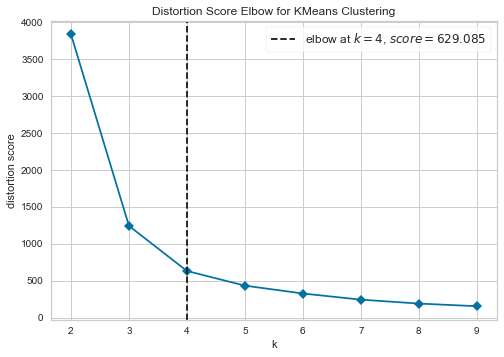

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [9]:
# méthode du coude (Elbow Method) pour déterminer k optimisé

model = KMeans()
visualizer = KElbowVisualizer(model, k=(2, 10), timings=False)
visualizer.fit(RFM_scaled)
visualizer.show()

In [180]:
# silhouette analysis
range_n_clusters = [2, 3, 4, 5, 6, 7]

for num_clusters in range_n_clusters:
    
    # intialise kmeans
    kmeans = KMeans(n_clusters=num_clusters)
    kmeans.fit(RFM_scaled)
    
    cluster_labels = kmeans.labels_
    
    # silhouette score
    silhouette_avg = silhouette_score(RFM_scaled, cluster_labels)
    print("For n_clusters={0}, the silhouette score is {1}".\
          @format(num_clusters, silhouette_avg))

For n_clusters=2, the silhouette score is 0.7783063739572044
For n_clusters=3, the silhouette score is 0.5936837302928745
For n_clusters=4, the silhouette score is 0.5707380024493253
For n_clusters=5, the silhouette score is 0.5456889006580526
For n_clusters=6, the silhouette score is 0.542112582394575
For n_clusters=7, the silhouette score is 0.537928785917632


In [9]:
# KMean avec k=5

kmeans = KMeans(n_clusters=5)
kmeans.fit(RFM_scaled)
kmeans.labels_

array([1, 1, 3, ..., 3, 1, 3], dtype=int32)

In [10]:
# assign the label

RFM['cluster_id_k5'] = kmeans.labels_
RFM

,Recency,Frequency,MonetaryValue,cluster_id_k5
customer_unique_id,,,,
0000366f3b9a7992bf8c76cfdf3221e2,161,1,141.90,1
0000b849f77a49e4a4ce2b2a4ca5be3f,164,1,27.19,1
0000f46a3911fa3c0805444483337064,586,1,86.22,3
0000f6ccb0745a6a4b88665a16c9f078,370,1,43.62,0
0004aac84e0df4da2b147fca70cf8255,337,1,196.89,0
...,...,...,...,...
fffcf5a5ff07b0908bd4e2dbc735a684,496,1,2067.42,3
fffea47cd6d3cc0a88bd621562a9d061,311,1,84.58,0
ffff371b4d645b6ecea244b27531430a,618,1,112.46,3


In [11]:
# Value moyenne de RFM pour chaque group client

resume_RFM = RFM.groupby('cluster_id_k5').agg({'Recency': "mean",
                                               'Frequency': "mean",
                                               'MonetaryValue': "mean"}).\
                                                round(2)
resume_RFM['clientNumber'] = RFM['cluster_id_k5'].value_counts()
resume_RFM

,Recency,Frequency,MonetaryValue,clientNumber
cluster_id_k5,,,,
0,364.70,1.0,161.29,24671
1,111.64,1.0,164.41,24989
2,311.95,2.5,167.03,2838
3,535.88,1.0,162.38,16631
4,233.37,1.0,157.16,26966


Text(0.5, 0, 'MonetaryValue')

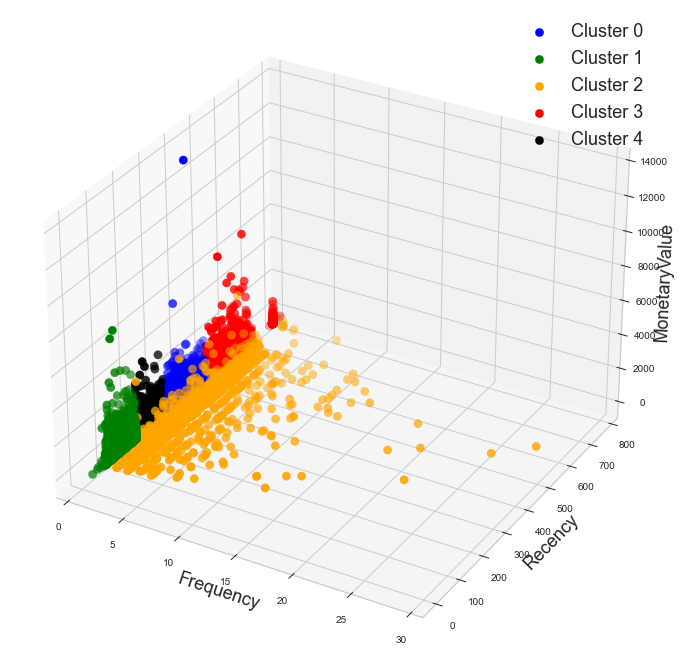

In [12]:
# Visualiser les groupes de client dans 3D RFM

fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(111, projection='3d')

scatter0 = ax.scatter(ys=RFM['Recency'][RFM['cluster_id_k5'] == 0],
                      xs=RFM['Frequency'][RFM['cluster_id_k5'] == 0],
                      zs=RFM['MonetaryValue'][RFM['cluster_id_k5'] == 0],
                      c='blue', s=70)

scatter1 = ax.scatter(ys=RFM['Recency'][RFM['cluster_id_k5'] == 1],
                      xs=RFM['Frequency'][RFM['cluster_id_k5'] == 1],
                      zs=RFM['MonetaryValue'][RFM['cluster_id_k5'] == 1],
                      c='green', s=70)

scatter2 = ax.scatter(ys=RFM['Recency'][RFM['cluster_id_k5'] == 2],
                      xs=RFM['Frequency'][RFM['cluster_id_k5'] == 2],
                      zs=RFM['MonetaryValue'][RFM['cluster_id_k5'] == 2],
                      c='orange', s=70)
scatter3 = ax.scatter(ys=RFM['Recency'][RFM['cluster_id_k5'] == 3],
                      xs=RFM['Frequency'][RFM['cluster_id_k5'] == 3],
                      zs=RFM['MonetaryValue'][RFM['cluster_id_k5'] == 3],
                      c='red', s=70)

scatter4 = ax.scatter(ys=RFM['Recency'][RFM['cluster_id_k5'] == 4],
                      xs=RFM['Frequency'][RFM['cluster_id_k5'] == 4],
                      zs=RFM['MonetaryValue'][RFM['cluster_id_k5'] == 4],
                      c='black', s=70)

ax.legend([scatter0, scatter1, scatter2, scatter3, scatter4],
          ['Cluster 0', 'Cluster 1', 'Cluster 2', 'Cluster 3', 'Cluster 4'],
          fontsize=18)

ax.set_xlabel('Frequency', fontsize=18)
ax.set_ylabel('Recency', fontsize=18)
ax.set_zlabel('MonetaryValue', fontsize=18)

/Users/vonhattam/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


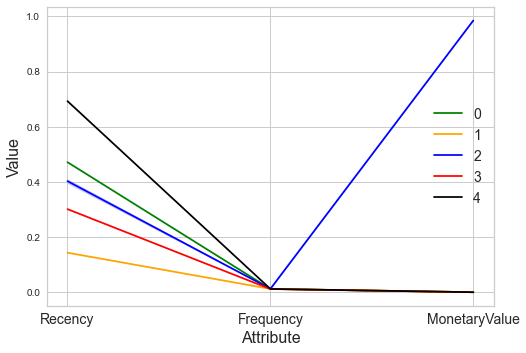

In [40]:
# Description des clusters

RFM_normalized = pd.DataFrame(RFM_scaled,
                              columns=['Recency',
                                       'Frequency',
                                       'MonetaryValue'])
RFM_normalized['ID'] = RFM.index
RFM_normalized["Cluster"] = kmeans.labels_

RFM_normalized_melted = pd.melt(RFM_normalized.reset_index(),
                                id_vars=["ID", "Cluster"],
                                value_vars=['Recency',
                                            'Frequency',
                                            'MonetaryValue'],
                                var_name="Attribute",
                                value_name="Value")

sns.lineplot("Attribute", "Value", hue="Cluster",
             data=RFM_normalized_melted,
             palette=['green', 'orange', 'blue', 'red', 'black'])
plt.xlabel('Attribute', fontsize=16)
plt.xticks(fontsize=14)
plt.ylabel('Value', fontsize=16)
plt.xticks(fontsize=14)
plt.legend(fontsize=14)
plt.show()

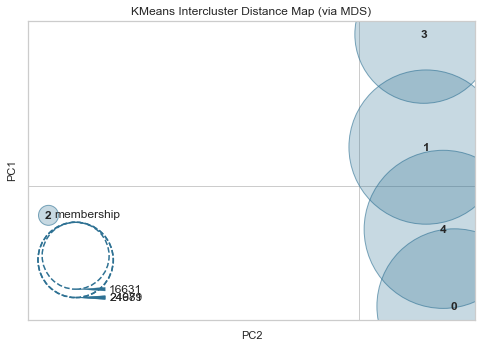

InterclusterDistance(ax=<AxesSubplot:title={'center':'KMeans Intercluster Distance Map (via MDS)'}, xlabel='PC2', ylabel='PC1'>,
                     estimator=KMeans(n_clusters=5))

In [41]:
from yellowbrick.cluster import intercluster_distance

intercluster_distance(KMeans(5), RFM_scaled)

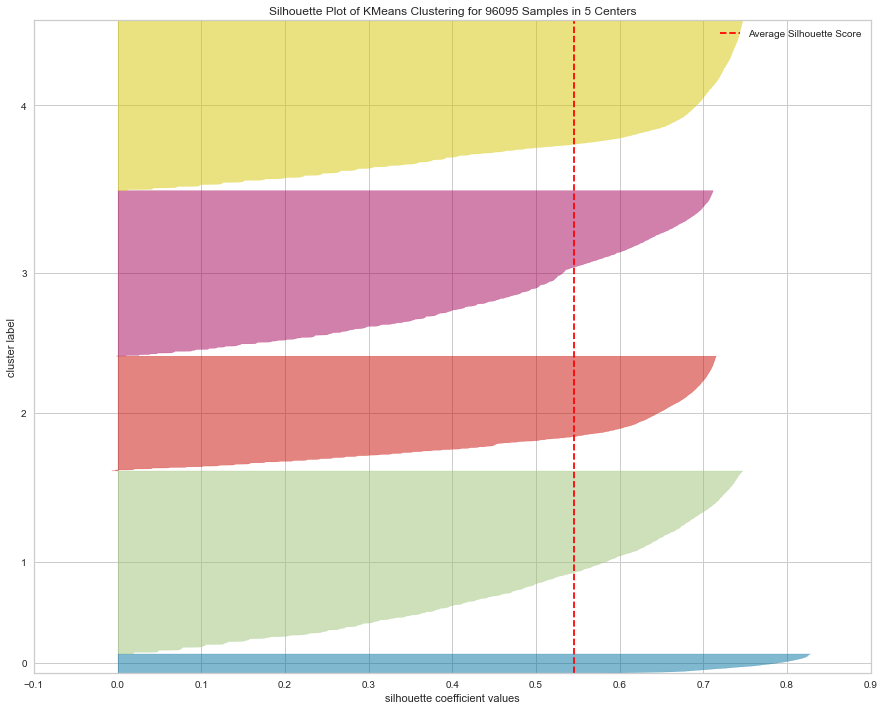

<AxesSubplot:title={'center':'Silhouette Plot of KMeans Clustering for 96095 Samples in 5 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [188]:
# Etudier la performance de modèle avec plot silhouette

plt.figure(figsize=(15, 12))
visualizer = SilhouetteVisualizer(kmeans, colors='yellowbrick')

visualizer.fit(RFM_scaled)
visualizer.show()

In [42]:
# Kmean avec k=3

kmeans = KMeans(n_clusters=3)
kmeans.fit(RFM_scaled)
kmeans.labels_

array([0, 0, 1, ..., 1, 0, 1], dtype=int32)

In [43]:
# assign the label

RFM['cluster_id_k3'] = kmeans.labels_
RFM

,Recency,Frequency,MonetaryValue,cluster_id_k5,cluster_id_k3
customer_unique_id,,,,,
0000366f3b9a7992bf8c76cfdf3221e2,161,1,141.90,1,0
0000b849f77a49e4a4ce2b2a4ca5be3f,164,1,27.19,1,0
0000f46a3911fa3c0805444483337064,586,1,86.22,4,1
0000f6ccb0745a6a4b88665a16c9f078,370,1,43.62,0,1
0004aac84e0df4da2b147fca70cf8255,337,1,196.89,0,1
...,...,...,...,...,...
fffcf5a5ff07b0908bd4e2dbc735a684,496,1,2067.42,4,1
fffea47cd6d3cc0a88bd621562a9d061,311,1,84.58,0,1
ffff371b4d645b6ecea244b27531430a,618,1,112.46,4,1


In [46]:
# Value moyenne de RFM pour chaque group client

resume_RFM = RFM.groupby('cluster_id_k3').agg({'Recency': "mean",
                                               'Frequency': "mean",
                                               'MonetaryValue': "mean"}).\
                                                round(2)
resume_RFM['clientNumber'] = RFM['cluster_id_k3'].value_counts()
resume_RFM

,Recency,Frequency,MonetaryValue,clientNumber
cluster_id_k3,,,,
0,179.02,1.0,160.59,53693
1,439.30,1.0,161.86,39564
2,311.95,2.5,167.03,2838


Text(0.5, 0, 'MonetaryValue')

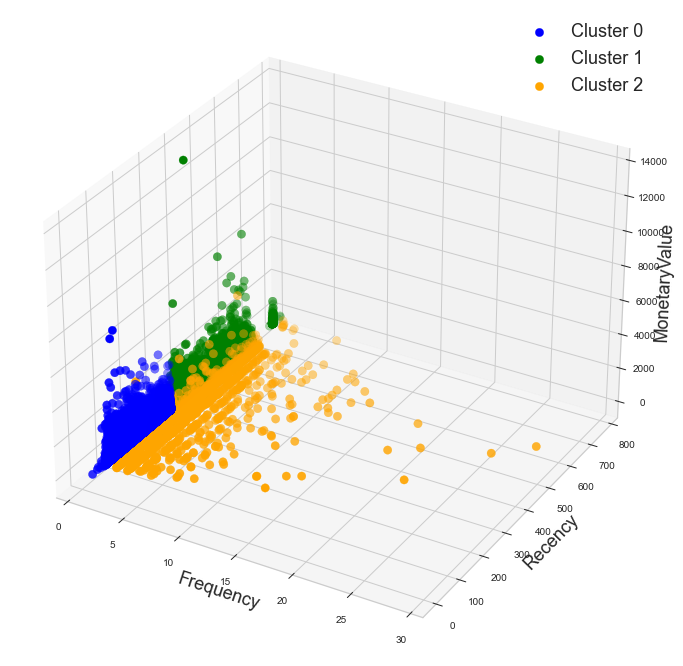

In [50]:
# Visualiser les groupes de client dans 3D RFM

fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(111, projection='3d')

scatter0 = ax.scatter(ys=RFM['Recency'][RFM['cluster_id_k3'] == 0],
                      xs=RFM['Frequency'][RFM['cluster_id_k3'] == 0],
                      zs=RFM['MonetaryValue'][RFM['cluster_id_k3'] == 0],
                      c='blue', s=70)

scatter1 = ax.scatter(ys=RFM['Recency'][RFM['cluster_id_k3'] == 1],
                      xs=RFM['Frequency'][RFM['cluster_id_k3'] == 1],
                      zs=RFM['MonetaryValue'][RFM['cluster_id_k3'] == 1],
                      c='green', s=70)

scatter2 = ax.scatter(ys=RFM['Recency'][RFM['cluster_id_k3'] == 2],
                      xs=RFM['Frequency'][RFM['cluster_id_k3'] == 2],
                      zs=RFM['MonetaryValue'][RFM['cluster_id_k3'] == 2],
                      c='orange', s=70)

ax.legend([scatter0, scatter1, scatter2],
          ['Cluster 0', 'Cluster 1', 'Cluster 2'],
          fontsize=18)

ax.set_xlabel('Frequency', fontsize=18)
ax.set_ylabel('Recency', fontsize=18)
ax.set_zlabel('MonetaryValue', fontsize=18)

/Users/vonhattam/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


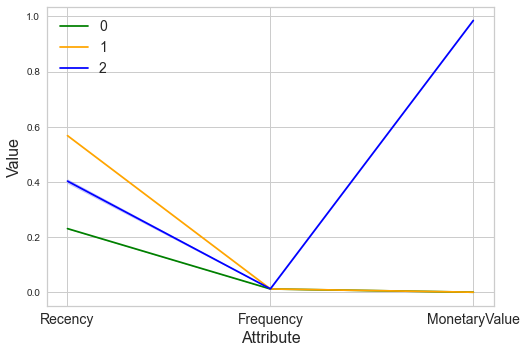

In [53]:
# Description des clusters

RFM_normalized = pd.DataFrame(RFM_scaled,
                              columns=['Recency',
                                       'Frequency',
                                       'MonetaryValue'])
RFM_normalized['ID'] = RFM.index
RFM_normalized["Cluster"] = kmeans.labels_

RFM_normalized_melted = pd.melt(RFM_normalized.reset_index(),
                                id_vars=["ID", "Cluster"],
                                value_vars=['Recency',
                                            'Frequency',
                                            'MonetaryValue'],
                                var_name="Attribute",
                                value_name="Value")

sns.lineplot("Attribute", "Value", hue="Cluster",
             data=RFM_normalized_melted,
             palette=['green', 'orange', 'blue'])
plt.xlabel('Attribute', fontsize=16)
plt.xticks(fontsize=14)
plt.ylabel('Value', fontsize=16)
plt.xticks(fontsize=14)
plt.legend(fontsize=14)
plt.show()

/Users/vonhattam/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_mds.py:441: UserWarning: The MDS API has changed. ``fit`` now constructs an dissimilarity matrix from data. To use a custom dissimilarity matrix, set ``dissimilarity='precomputed'``.
  warnings.warn("The MDS API has changed. ``fit`` now constructs an"


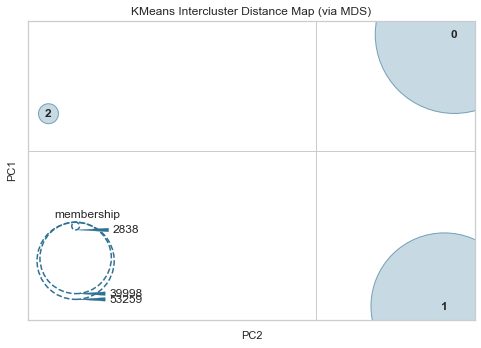

InterclusterDistance(ax=<AxesSubplot:title={'center':'KMeans Intercluster Distance Map (via MDS)'}, xlabel='PC2', ylabel='PC1'>,
                     estimator=KMeans(n_clusters=3))

In [54]:
from yellowbrick.cluster import intercluster_distance

intercluster_distance(KMeans(3), RFM_scaled)

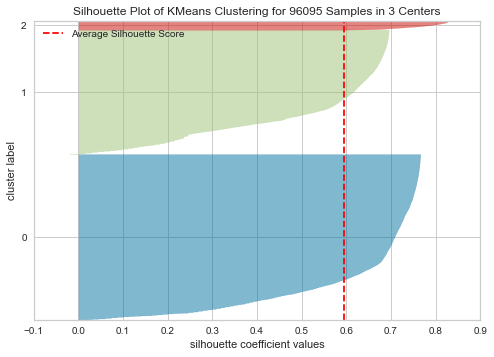

<AxesSubplot:title={'center':'Silhouette Plot of KMeans Clustering for 96095 Samples in 3 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [10]:
# Etudier la performance de modèle avec plot silhouette

visualizer = SilhouetteVisualizer(kmeans, colors='yellowbrick')
visualizer.fit(RFM_scaled)

visualizer.show()

In [16]:
# KMean avec k=4

kmeans = KMeans(n_clusters=4)
kmeans.fit(RFM_scaled)
kmeans.labels_

array([0, 0, 1, ..., 1, 0, 1], dtype=int32)

In [17]:
# assign the label

RFM['cluster_id_k4'] = kmeans.labels_
RFM

,Recency,Frequency,MonetaryValue,cluster_id_k5,cluster_id_k4
customer_unique_id,,,,,
0000366f3b9a7992bf8c76cfdf3221e2,161,1,141.90,1,0
0000b849f77a49e4a4ce2b2a4ca5be3f,164,1,27.19,1,0
0000f46a3911fa3c0805444483337064,586,1,86.22,3,1
0000f6ccb0745a6a4b88665a16c9f078,370,1,43.62,0,3
0004aac84e0df4da2b147fca70cf8255,337,1,196.89,0,3
...,...,...,...,...,...
fffcf5a5ff07b0908bd4e2dbc735a684,496,1,2067.42,3,1
fffea47cd6d3cc0a88bd621562a9d061,311,1,84.58,0,3
ffff371b4d645b6ecea244b27531430a,618,1,112.46,3,1


In [18]:
# Values moyennes de RFM pour chaque group client

resume_RFM = RFM.groupby('cluster_id_k4').agg({'Recency': "mean",
                                               'Frequency': "mean",
                                               'MonetaryValue': "mean"}).\
                                                round(2)
resume_RFM['clientNumber'] = RFM['cluster_id_k4'].value_counts()
resume_RFM

,Recency,Frequency,MonetaryValue,clientNumber
cluster_id_k4,,,,
0,136.82,1.0,164.80,35531
1,508.75,1.0,161.81,22256
2,311.95,2.5,167.03,2838
3,304.73,1.0,157.02,35470


<AxesSubplot:xlabel='cluster_id_k4', ylabel='MonetaryValue'>

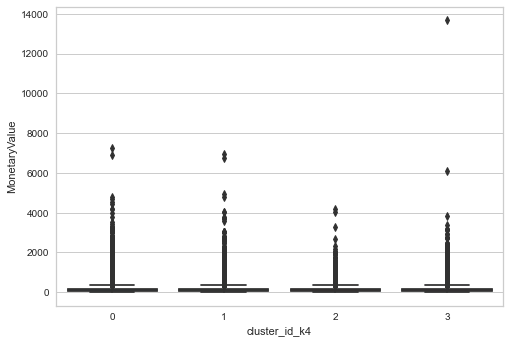

In [19]:
sns.boxplot(x='cluster_id_k4', y='MonetaryValue', data=RFM)

<AxesSubplot:xlabel='cluster_id_k4', ylabel='Frequency'>

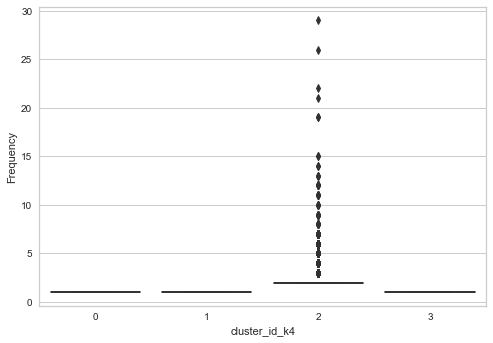

In [20]:
sns.boxplot(x='cluster_id_k4', y='Frequency', data=RFM)

<AxesSubplot:xlabel='cluster_id_k4', ylabel='Recency'>

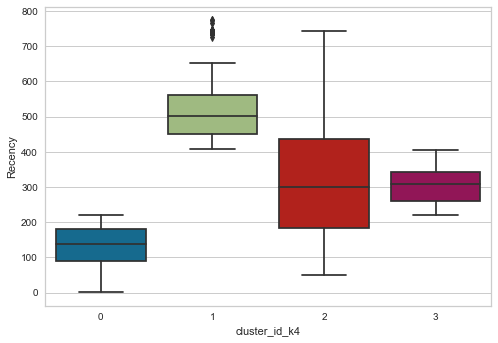

In [21]:
sns.boxplot(x='cluster_id_k4', y='Recency', data=RFM)

Text(0.5, 0, 'MonetaryValue')

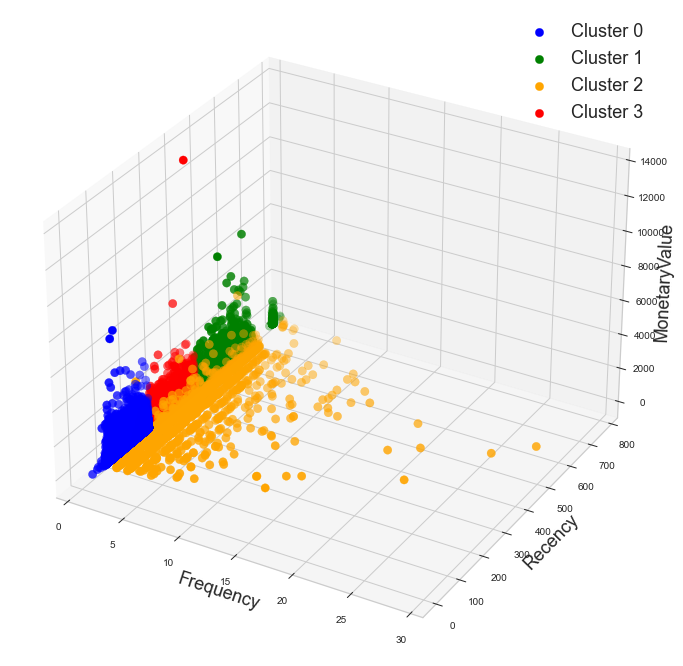

In [22]:
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(111, projection='3d')

scatter0 = ax.scatter(ys=RFM['Recency'][RFM['cluster_id_k4'] == 0],
                      xs=RFM['Frequency'][RFM['cluster_id_k4'] == 0],
                      zs=RFM['MonetaryValue'][RFM['cluster_id_k4'] == 0],
                      c='blue', s=70)

scatter1 = ax.scatter(ys=RFM['Recency'][RFM['cluster_id_k4'] == 1],
                      xs=RFM['Frequency'][RFM['cluster_id_k4'] == 1],
                      zs=RFM['MonetaryValue'][RFM['cluster_id_k4'] == 1],
                      c='green', s=70)

scatter2 = ax.scatter(ys=RFM['Recency'][RFM['cluster_id_k4'] == 2],
                      xs=RFM['Frequency'][RFM['cluster_id_k4'] == 2],
                      zs=RFM['MonetaryValue'][RFM['cluster_id_k4'] == 2],
                      c='orange', s=70)
scatter3 = ax.scatter(ys=RFM['Recency'][RFM['cluster_id_k4'] == 3],
                      xs=RFM['Frequency'][RFM['cluster_id_k4'] == 3],
                      zs=RFM['MonetaryValue'][RFM['cluster_id_k4'] == 3],
                      c='red', s=70)

ax.legend([scatter0, scatter1, scatter2, scatter3],
          ['Cluster 0', 'Cluster 1', 'Cluster 2', 'Cluster 3'],
          fontsize=18)

ax.set_xlabel('Frequency', fontsize=18)
ax.set_ylabel('Recency', fontsize=18)
ax.set_zlabel('MonetaryValue', fontsize=18)

/Users/vonhattam/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


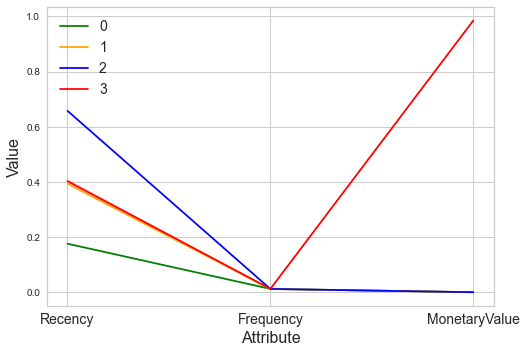

In [65]:
# Description des clusters

RFM_normalized = pd.DataFrame(RFM_scaled,
                              columns=['Recency',
                                       'Frequency',
                                       'MonetaryValue'])
RFM_normalized['ID'] = RFM.index
RFM_normalized["Cluster"] = kmeans.labels_

RFM_normalized_melted = pd.melt(RFM_normalized.reset_index(),
                                id_vars=["ID", "Cluster"],
                                value_vars=['Recency',
                                            'Frequency',
                                            'MonetaryValue'],
                                var_name="Attribute",
                                value_name="Value")

sns.lineplot("Attribute", "Value", hue="Cluster",
             data=RFM_normalized_melted,
             palette=['green', 'orange', 'blue', 'red'])
plt.xlabel('Attribute', fontsize=16)
plt.xticks(fontsize=14)
plt.ylabel('Value', fontsize=16)
plt.xticks(fontsize=14)
plt.legend(fontsize=14)
plt.show()

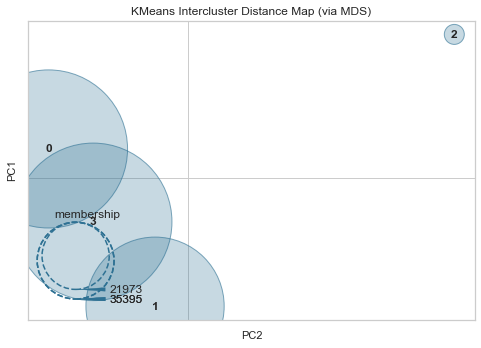

InterclusterDistance(ax=<AxesSubplot:title={'center':'KMeans Intercluster Distance Map (via MDS)'}, xlabel='PC2', ylabel='PC1'>,
                     estimator=KMeans(n_clusters=4))

In [66]:
from yellowbrick.cluster import intercluster_distance

intercluster_distance(KMeans(4), RFM_scaled)

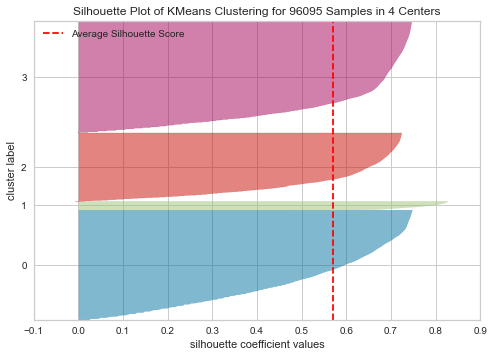

<AxesSubplot:title={'center':'Silhouette Plot of KMeans Clustering for 96095 Samples in 4 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [21]:
# Etudier la performance de modèle avec plot silhouette

visualizer = SilhouetteVisualizer(kmeans, colors='yellowbrick')

visualizer.fit(RFM_scaled)
visualizer.show()

# II. Stabilité de Segmentation RFM (KMean, k =4)

In [68]:
# les clients en période initiale t0 (ancienneté > 1 ans)

data_init = RFM[RFM['Recency'] >= 361]

In [70]:
# Normaliser les données

scaler_minmax = MinMaxScaler()
scaler_quan = QuantileTransformer()
RM = ['Recency', 'MonetaryValue']
FM = ['Frequency']
scaler = ColumnTransformer(transformers=[('RM', scaler_minmax, RM),
                                         ('F', scaler_quan, F)])
# KMean pour les données en période initiale

kmeans_init = Pipeline([("preprocessor", scaler),
                        ("kmeans", KMeans(4))])
kmeans_init.fit(data_init)
init_labels = kmeans_init.named_steps['kmeans'].labels_
init_labels = pd.DataFrame({'labels': init_labels}, index=data_init.index)

In [73]:
# Calculer ARI score pour les durées de 1 mois (30 jour)
ari_score = []
for p in np.arange(30, 361, 30):
    # Créer les donnés pour les périodes t1, t2, ...
    data_period = RFM[RFM['Recency'] >= (361-p)]
    # K-Means
    kmeans_p = Pipeline([("preprocessor", scaler),
                         ("kmeans", KMeans(4))])
    kmeans_p.fit(data_period)
    p_labels = kmeans_p.named_steps['kmeans'].labels_
    p_labels = pd.DataFrame({'labels': p_labels}, index=data_period.index)
    p_labels = p_labels[p_labels.index.isin(init_labels.index)]
    # Calculer ARI score
    ari_p = adjusted_rand_score(init_labels.labels.values,
                                p_labels.labels.values)
    ari_score.append([p, ari_p])

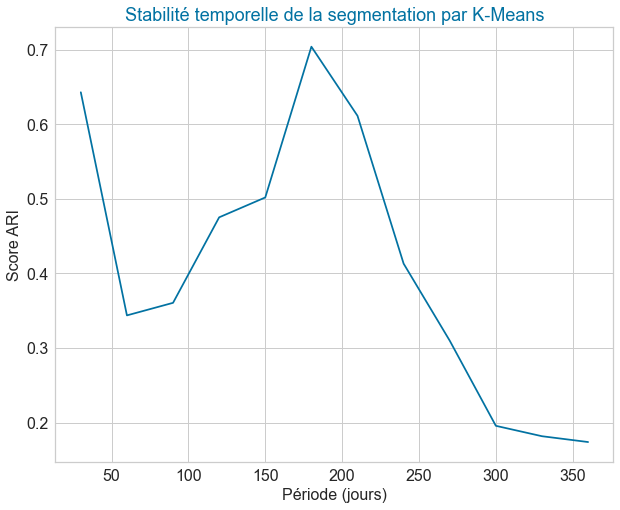

In [75]:
ari_score = pd.DataFrame(ari_score, columns=["periode", "ARI"])

# plot ARI Score
fig = plt.figure(figsize=(10, 8))
sns.lineplot(data=ari_score, x="periode", y="ARI")
plt.xlabel("Période (jours)", fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.ylabel("Score ARI", fontsize=16)
plt.title("Stabilité temporelle de la segmentation par K-Means",
          fontsize=18,
          color="b")
plt.show()

In [141]:
# les clients en période initiale t0 (ancienneté > 1 mois)

data_init = RFM[RFM['Recency'] >= 31]

In [142]:
# Normaliser les données

scaler_minmax = MinMaxScaler()
scaler_quan = QuantileTransformer()
RM = ['Recency', 'MonetaryValue']
FM = ['Frequency']
scaler = ColumnTransformer(transformers=[('RM', scaler_minmax, RM),
                                         ('F', scaler_quan, F)])
# KMean pour les données en période initiale

kmeans_init = Pipeline([("preprocessor", scaler),
                        ("kmeans", KMeans(4))])
kmeans_init.fit(data_init)
init_labels = kmeans_init.named_steps['kmeans'].labels_
init_labels = pd.DataFrame({'labels': init_labels}, index=data_init.index)

In [143]:
# Calculer ARI score pour les durées de 1 mois (30 jour)
ari_score = []
for p in np.arange(1, 31, 1):
    # Créer les donnés pour les périodes t1, t2, ...
    
    data_period = RFM[RFM['Recency'] >= (31-p)]

    # K-Means
    kmeans_p = Pipeline([("preprocessor", scaler),
                         ("kmeans", KMeans(4))])
    kmeans_p.fit(data_period)
    p_labels = kmeans_p.named_steps['kmeans'].labels_
    p_labels = pd.DataFrame({'labels': p_labels}, index=data_period.index)
    p_labels = p_labels[p_labels.index.isin(init_labels.index)]
    
    # Calculer ARI score
    ari_p = adjusted_rand_score(init_labels.labels.values,
                                p_labels.labels.values)
    ari_score.append([p,ari_p])

/Users/vonhattam/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/cluster/_supervised.py:389: RuntimeWarning: overflow encountered in long_scalars
  return 2. * (tp * tn - fn * fp) / ((tp + fn) * (fn + tn) +
/Users/vonhattam/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/cluster/_supervised.py:390: RuntimeWarning: overflow encountered in long_scalars
  (tp + fp) * (fp + tn))
/Users/vonhattam/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/cluster/_supervised.py:389: RuntimeWarning: overflow encountered in long_scalars
  return 2. * (tp * tn - fn * fp) / ((tp + fn) * (fn + tn) +
/Users/vonhattam/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/cluster/_supervised.py:390: RuntimeWarning: overflow encountered in long_scalars
  (tp + fp) * (fp + tn))
/Users/vonhattam/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/cluster/_supervised.py:389: RuntimeWarning: overflow encountered in long_scalars
  return 2. * (tp * tn - fn * fp) / ((tp + fn) *

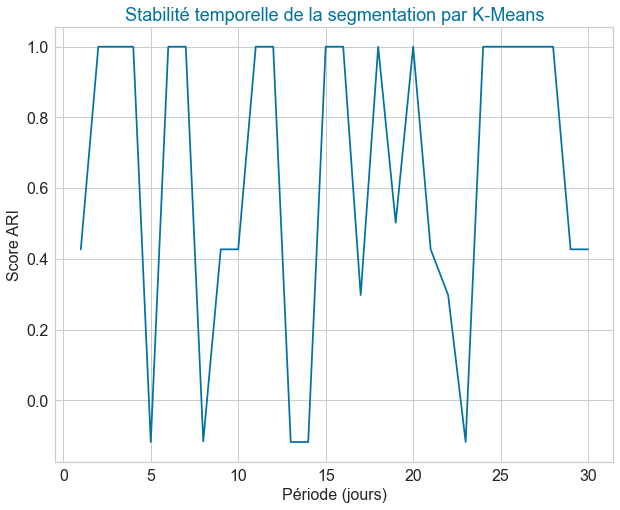

In [144]:
ari_score = pd.DataFrame(ari_score, columns=["periode", "ARI"])

# plot ARI Score
fig = plt.figure(figsize=(10, 8))
sns.lineplot(data=ari_score, x="periode", y="ARI")
plt.xlabel("Période (jours)", fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize = 16)
plt.ylabel("Score ARI", fontsize=16)
plt.title("Stabilité temporelle de la segmentation par K-Means",
          fontsize=18,
          color="b")
plt.show()

# III. Segmentation RFM et Avis de client (KMeans)

In [76]:
RFM_R = data[['Recency', 'Frequency', 'MonetaryValue', 'review_score']]

In [78]:
# Normaliser les données


scaler_minmax = MinMaxScaler()
scaler_quan = QuantileTransformer()
RMR = ['Recency', 'MonetaryValue', 'review_score']
F = ['Frequency']
scaler = ColumnTransformer(transformers=[('RMR', scaler_minmax, RMR),
                                         ('F', scaler_quan, F)])
RFM_R_scaled = scaler.fit_transform(RFM_R)

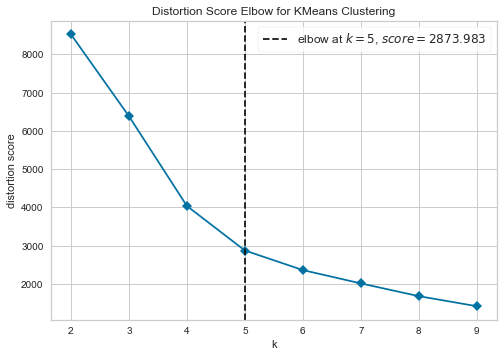

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [79]:
model = KMeans()
visualizer = KElbowVisualizer(model, k=(2, 10), timings=False)
visualizer.fit(RFM_R_scaled)
visualizer.show()

In [10]:
# silhouette analysis
range_n_clusters = [2, 3, 4, 5, 6, 7]

for num_clusters in range_n_clusters:
    
    # intialise kmeans
    kmeans = KMeans(n_clusters=num_clusters)
    kmeans.fit(RFM_R_scaled)
    
    cluster_labels = kmeans.labels_
    
    # silhouette score
    silhouette_avg = silhouette_score(RFM_R_scaled, cluster_labels)
    print("For n_clusters={0}, the silhouette score is {1}".\
          format(num_clusters, silhouette_avg))

For n_clusters=2, the silhouette score is 0.6598797248259926
For n_clusters=3, the silhouette score is 0.6882884876146915
For n_clusters=4, the silhouette score is 0.6075732882854589
For n_clusters=5, the silhouette score is 0.5198938814484253
For n_clusters=6, the silhouette score is 0.5270115618481244
For n_clusters=7, the silhouette score is 0.5321297657672932


In [80]:
# KMean avec k=4

kmeans = KMeans(n_clusters=4)
kmeans.fit(RFM_R_scaled)
kmeans.labels_

array([0, 0, 3, ..., 3, 0, 3], dtype=int32)

In [81]:
# assign the label

RFM_R['cluster_id_k4'] = kmeans.labels_
RFM_R

,Recency,Frequency,MonetaryValue,review_score,cluster_id_k4
customer_unique_id,,,,,
0000366f3b9a7992bf8c76cfdf3221e2,161,1,141.90,5.0,0
0000b849f77a49e4a4ce2b2a4ca5be3f,164,1,27.19,4.0,0
0000f46a3911fa3c0805444483337064,586,1,86.22,3.0,3
0000f6ccb0745a6a4b88665a16c9f078,370,1,43.62,4.0,3
0004aac84e0df4da2b147fca70cf8255,337,1,196.89,5.0,3
...,...,...,...,...,...
fffcf5a5ff07b0908bd4e2dbc735a684,496,1,2067.42,5.0,3
fffea47cd6d3cc0a88bd621562a9d061,311,1,84.58,4.0,3
ffff371b4d645b6ecea244b27531430a,618,1,112.46,5.0,3


In [83]:
# Values moyennes de RFM_Avis pour chaque group client

resume_RFM_R = RFM_R.groupby('cluster_id_k4').agg({'Recency': "mean",
                                                   'Frequency': "mean",
                                                   'MonetaryValue': "mean",
                                                   'review_score': "mean"}).\
                                                    round(2)
resume_RFM_R['clientNumber'] = RFM_R['cluster_id_k4'].value_counts()
resume_RFM_R

,Recency,Frequency,MonetaryValue,review_score,clientNumber
cluster_id_k4,,,,,
0,175.68,1.0,155.46,4.76,41589
1,287.93,1.0,177.33,1.83,20624
2,311.95,2.5,167.03,4.06,2838
3,442.85,1.0,157.95,4.71,31044


/Users/vonhattam/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


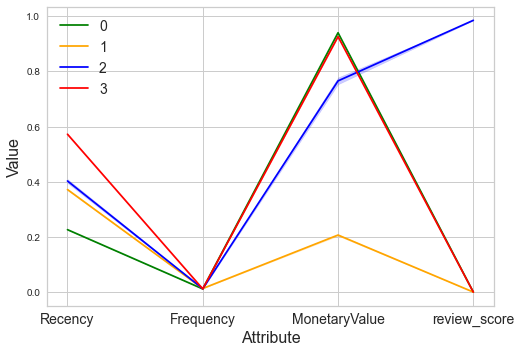

22:48: E231 missing whitespace after ','


In [85]:
# Description des clusters

RFM_R_normalized = pd.DataFrame(RFM_R_scaled,
                                columns=['Recency',
                                         'Frequency',
                                         'MonetaryValue',
                                         'review_score'])
RFM_R_normalized['ID'] = RFM_R.index
RFM_R_normalized["Cluster"] = kmeans.labels_

RFM_R_normalized_melted = pd.melt(RFM_R_normalized.reset_index(),
                                  id_vars=["ID", "Cluster"],
                                  value_vars=['Recency',
                                              'Frequency',
                                              'MonetaryValue',
                                              'review_score'],
                                  var_name="Attribute",
                                  value_name="Value")

sns.lineplot("Attribute", "Value", hue="Cluster",
             data=RFM_R_normalized_melted,
             palette=['green', 'orange', 'blue','red'])
plt.xlabel('Attribute', fontsize=16)
plt.xticks(fontsize=14)
plt.ylabel('Value', fontsize=16)
plt.xticks(fontsize=14)
plt.legend(fontsize=14)
plt.show()

/Users/vonhattam/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_mds.py:441: UserWarning: The MDS API has changed. ``fit`` now constructs an dissimilarity matrix from data. To use a custom dissimilarity matrix, set ``dissimilarity='precomputed'``.
  warnings.warn("The MDS API has changed. ``fit`` now constructs an"


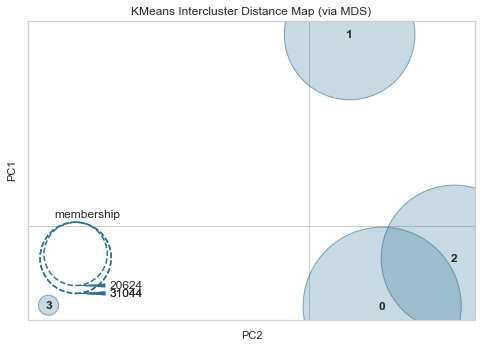

InterclusterDistance(ax=<AxesSubplot:title={'center':'KMeans Intercluster Distance Map (via MDS)'}, xlabel='PC2', ylabel='PC1'>,
                     estimator=KMeans(n_clusters=4))

In [86]:
from yellowbrick.cluster import intercluster_distance

intercluster_distance(KMeans(4), RFM_R_scaled)

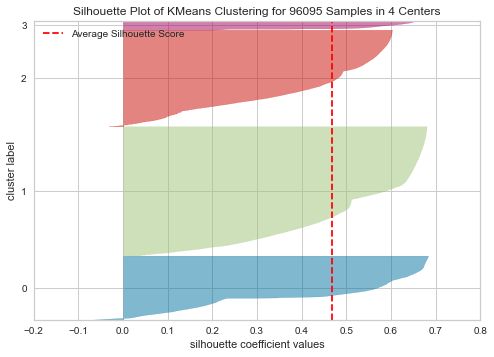

<AxesSubplot:title={'center':'Silhouette Plot of KMeans Clustering for 96095 Samples in 4 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [156]:
# Etudier la performance de modèle avec plot silhouette

visualizer = SilhouetteVisualizer(kmeans, colors='yellowbrick')

visualizer.fit(RFM_R_scaled)
visualizer.show()

In [87]:
# final model with k=3

kmeans = KMeans(n_clusters=3)
kmeans.fit(RFM_R_scaled)
kmeans.labels_

array([1, 1, 0, ..., 1, 1, 1], dtype=int32)

In [88]:
# assign the label

RFM_R['cluster_id_k3'] = kmeans.labels_
RFM_R

,Recency,Frequency,MonetaryValue,review_score,cluster_id_k4,cluster_id_k3
customer_unique_id,,,,,,
0000366f3b9a7992bf8c76cfdf3221e2,161,1,141.90,5.0,0,1
0000b849f77a49e4a4ce2b2a4ca5be3f,164,1,27.19,4.0,0,1
0000f46a3911fa3c0805444483337064,586,1,86.22,3.0,3,0
0000f6ccb0745a6a4b88665a16c9f078,370,1,43.62,4.0,3,1
0004aac84e0df4da2b147fca70cf8255,337,1,196.89,5.0,3,1
...,...,...,...,...,...,...
fffcf5a5ff07b0908bd4e2dbc735a684,496,1,2067.42,5.0,3,1
fffea47cd6d3cc0a88bd621562a9d061,311,1,84.58,4.0,3,1
ffff371b4d645b6ecea244b27531430a,618,1,112.46,5.0,3,1


In [90]:
# Values moyennes de RFM_Avis pour chaque group client

resume_RFM_R = RFM_R.groupby('cluster_id_k3').agg({'Recency': "mean",
                                                   'Frequency': "mean",
                                                   'MonetaryValue': "mean",
                                                   'review_score': "mean"}).\
                                                    round(2)
resume_RFM_R['clientNumber'] = RFM_R['cluster_id_k3'].value_counts()
resume_RFM_R

,Recency,Frequency,MonetaryValue,review_score,clientNumber
cluster_id_k3,,,,,
0,296.16,1.0,176.57,1.86,21190
1,287.47,1.0,156.59,4.75,72067
2,311.95,2.5,167.03,4.06,2838


/Users/vonhattam/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


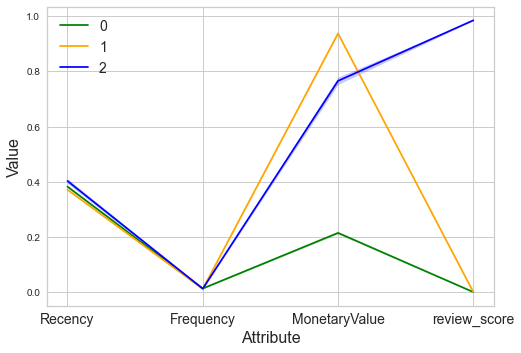

In [92]:
# Description des clusters

RFM_R_normalized = pd.DataFrame(RFM_R_scaled,
                                columns=['Recency',
                                         'Frequency',
                                         'MonetaryValue',
                                         'review_score'])
RFM_R_normalized['ID'] = RFM_R.index
RFM_R_normalized["Cluster"] = kmeans.labels_

RFM_R_normalized_melted = pd.melt(RFM_R_normalized.reset_index(),
                                  id_vars=["ID", "Cluster"],
                                  value_vars=['Recency',
                                              'Frequency',
                                              'MonetaryValue',
                                              'review_score'],
                                  var_name="Attribute",
                                  value_name="Value")

sns.lineplot("Attribute", "Value", hue="Cluster",
             data=RFM_R_normalized_melted,
             palette=['green', 'orange', 'blue'])
plt.xlabel('Attribute', fontsize=16)
plt.xticks(fontsize=14)
plt.ylabel('Value', fontsize=16)
plt.xticks(fontsize=14)
plt.legend(fontsize=14)
plt.show()

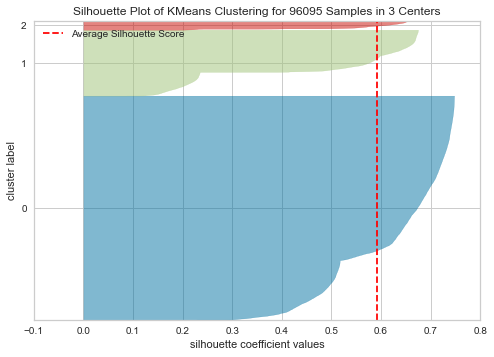

<AxesSubplot:title={'center':'Silhouette Plot of KMeans Clustering for 96095 Samples in 3 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [36]:
# Etudier la performance de modèle avec plot silhouette

visualizer = SilhouetteVisualizer(kmeans, colors='yellowbrick')

visualizer.fit(RFM_R_scaled)
visualizer.show()

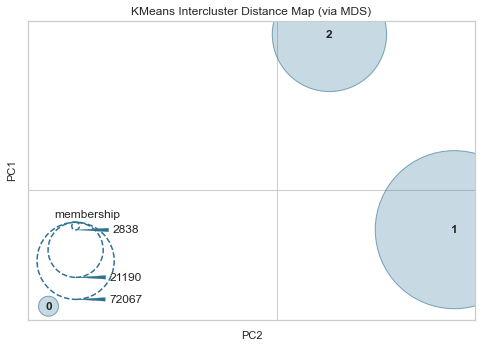

InterclusterDistance(ax=<AxesSubplot:title={'center':'KMeans Intercluster Distance Map (via MDS)'}, xlabel='PC2', ylabel='PC1'>,
                     estimator=KMeans(n_clusters=3))

In [93]:
from yellowbrick.cluster import intercluster_distance

intercluster_distance(KMeans(3), RFM_R_scaled)

# IV. Stabilité de Segmentation RFM (KMean, k =3)

In [94]:
RFM_R = data[['Recency', 'Frequency', 'MonetaryValue', 'review_score']]

In [108]:
# les clients en période initiale t0 (ancienneté > 1 ans)

data_init = RFM_R[RFM_R['Recency'] >= 361]

In [109]:
# Normaliser les données

scaler_minmax = MinMaxScaler()
scaler_quan = QuantileTransformer()
RMR = ['Recency', 'MonetaryValue', 'review_score']
FM = ['Frequency']
scaler = ColumnTransformer(transformers=[('RMR', scaler_minmax, RMR),
                                         ('F', scaler_quan, F)])
# KMean pour les données en période initiale

kmeans_init = Pipeline([("preprocessor", scaler),
                        ("kmeans", KMeans(3))])
kmeans_init.fit(data_init)
init_labels = kmeans_init.named_steps['kmeans'].labels_
init_labels = pd.DataFrame({'labels': init_labels}, index=data_init.index)

In [110]:
# Calculer ARI score pour les durées de 1 mois (30 jour)
ari_score = []
for p in np.arange(30, 361, 30):
    # Créer les donnés pour les périodes t1, t2, ...
    data_period = RFM_R[RFM_R['Recency'] >= (361-p)]
    # K-Means
    kmeans_p = Pipeline([("preprocessor", scaler),
                         ("kmeans", KMeans(3))])
    kmeans_p.fit(data_period)
    p_labels = kmeans_p.named_steps['kmeans'].labels_
    p_labels = pd.DataFrame({'labels': p_labels}, index=data_period.index)
    p_labels = p_labels[p_labels.index.isin(init_labels.index)]
    # Calculer ARI score
    ari_p = adjusted_rand_score(init_labels.labels.values,
                                p_labels.labels.values)
    ari_score.append([p, ari_p])

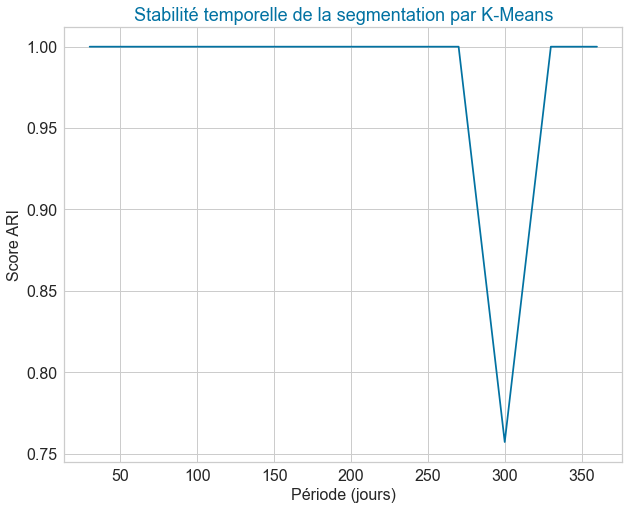

In [111]:
ari_score = pd.DataFrame(ari_score, columns=["periode", "ARI"])

# plot ARI Score
fig = plt.figure(figsize=(10, 8))
sns.lineplot(data=ari_score, x="periode", y="ARI")
plt.xlabel("Période (jours)", fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.ylabel("Score ARI", fontsize=16)
plt.title("Stabilité temporelle de la segmentation par K-Means",
          fontsize=18,
          color="b")
plt.show()

In [244]:
# les clients en période initiale t0 (ancienneté > 6 mois)

data_init = RFM_R[RFM_R['Recency'] >= 181]

In [112]:
# Normaliser les données

scaler_minmax = MinMaxScaler()
scaler_quan = QuantileTransformer()
RMR = ['Recency', 'MonetaryValue', 'review_score']
FM = ['Frequency']
scaler = ColumnTransformer(transformers=[('RMR', scaler_minmax, RMR),
                                         ('F', scaler_quan, F)])
# KMean pour les données en période initiale

kmeans_init = Pipeline([("preprocessor", scaler),
                        ("kmeans", KMeans(3))])
kmeans_init.fit(data_init)
init_labels = kmeans_init.named_steps['kmeans'].labels_
init_labels = pd.DataFrame({'labels': init_labels}, index=data_init.index)

In [113]:
# Calculer ARI score pour les durées de 1 mois (30 jour)
ari_score = []
for p in np.arange(30, 181, 30):
    # Créer les donnés pour les périodes t1, t2, ...
    data_period = RFM_R[RFM_R['Recency'] >= (181-p)]
    # K-Means
    kmeans_p = Pipeline([("preprocessor", scaler),
                         ("kmeans", KMeans(3))])
    kmeans_p.fit(data_period)
    p_labels = kmeans_p.named_steps['kmeans'].labels_
    p_labels = pd.DataFrame({'labels': p_labels}, index=data_period.index)
    p_labels = p_labels[p_labels.index.isin(init_labels.index)]
    # Calculer ARI score
    ari_p = adjusted_rand_score(init_labels.labels.values,
                                p_labels.labels.values)
    ari_score.append([p, ari_p])

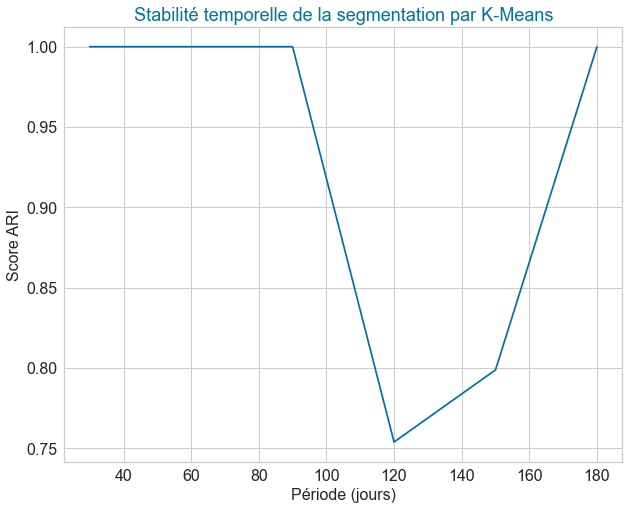

In [115]:
ari_score = pd.DataFrame(ari_score, columns=["periode", "ARI"])

# plot ARI Score
fig = plt.figure(figsize=(10, 8))
sns.lineplot(data=ari_score, x="periode", y="ARI")
plt.xlabel("Période (jours)", fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.ylabel("Score ARI", fontsize=16)
plt.title("Stabilité temporelle de la segmentation par K-Means",
          fontsize=18,
          color="b")
plt.show()

# V. AgglomerativeClustering avec RMF_Avis

In [118]:
RFM_R = data[['Recency', 'Frequency', 'MonetaryValue', 'review_score']]

# j'ai testé sur 5% de donné car il prends beaucoup de temps avec 96k clients

choix = RFM_R.sample(frac=0.05)
choix

,Recency,Frequency,MonetaryValue,review_score
customer_unique_id,,,,
d0636d06234b819bab25726c803ccda7,495,1,51.75,1.0
b6bb8e4780df00a25fa34335d3dc1330,401,1,62.78,5.0
f672d4ae866d742fc72d3b4c4d2cf23d,410,1,166.71,5.0
1ad84d1ab5998f0c9c3564cec9a4c2d5,155,1,69.77,5.0
b3294719433aa4945f6399c5eab2bb1f,296,1,182.91,5.0
...,...,...,...,...
a11abd71911b5cf2d046abeaa4e2d426,91,1,45.28,5.0
fadd744a945e92efba1b56fff793724b,63,1,76.28,5.0
87ea2314191dfd4a1f88c0eaf01b7b2f,271,1,106.87,1.0


In [120]:
# Normaliser les données

scaler_robust = RobustScaler()
scaler_minmax = MinMaxScaler()
scaler_quan = QuantileTransformer()
RR = ['Recency', 'MonetaryValue', 'review_score']
FM = ['Frequency']
scaler = ColumnTransformer(transformers=[('RR', scaler_minmax, RR),
                                         ('FM', scaler_quan, FM)])
choix_scaled = scaler.fit_transform(choix)

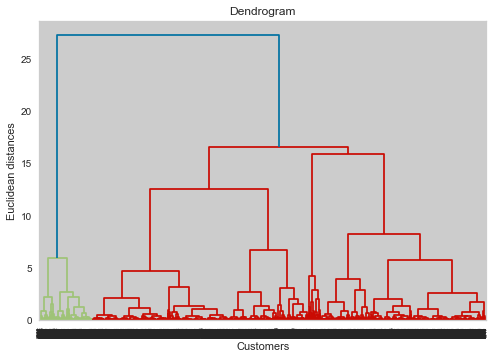

In [6]:
dendrogram = sch.dendrogram(sch.linkage(choix_scaled, method="ward"))
plt.title('Dendrogram')
plt.xlabel('Customers')
plt.ylabel('Euclidean distances')
plt.show()

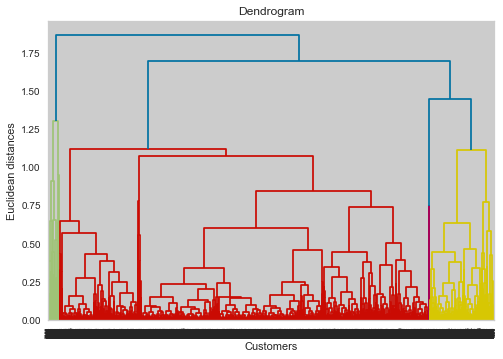

In [7]:
dendrogram = sch.dendrogram(sch.linkage(choix_scaled, method="complete"))
plt.title('Dendrogram')
plt.xlabel('Customers')
plt.ylabel('Euclidean distances')
plt.show()

In [122]:
# AgglomerativeClustering avec 3 groups de clients

cluster = AgglomerativeClustering(n_clusters=3, linkage='complete')
cluster.fit(choix_scaled)
choix['cluster_id'] = cluster.labels_

# Déscrire trois groupes
resume_choix = choix.groupby('cluster_id').agg({'Recency': "mean",
                                                'Frequency': "mean",
                                                'MonetaryValue': "mean",
                                                'review_score': "mean"}).\
                                                round(2)
resume_choix['clientNumber'] = choix['cluster_id'].value_counts()
resume_choix

,Recency,Frequency,MonetaryValue,review_score,clientNumber
cluster_id,,,,,
0,293.86,1.00,198.49,1.20,686
1,336.16,2.48,179.88,4.01,160
2,287.42,1.00,156.28,4.57,3959


#  VI. DBSCAN avec RFM_Avis

In [123]:
RFM_R = data[['Recency', 'Frequency', 'MonetaryValue', 'review_score']]

In [5]:
#Normaliser des données

scaler_minmax = MinMaxScaler()
scaler_quan = QuantileTransformer()
RR = ['Recency', 'MonetaryValue']
FM = ['Frequency', 'review_score']
scaler = ColumnTransformer(transformers=[('RR', scaler_minmax, RR),
                                         ('FM', scaler_quan, FM)])
RFM_R_scaled = scaler.fit_transform(RFM_R)

In [6]:
# DBSCAN avec eps et min_samples par défaut

dbscan = DBSCAN()
dbscan.fit(RFM_R_scaled)
dbscan.labels_

array([0, 1, 1, ..., 0, 0, 0])

In [7]:
# assign the label

RFM_R['cluster_id'] = dbscan.labels_
RFM_R

,Recency,Frequency,MonetaryValue,review_score,cluster_id
customer_unique_id,,,,,
0000366f3b9a7992bf8c76cfdf3221e2,161,1,141.90,5.0,0
0000b849f77a49e4a4ce2b2a4ca5be3f,164,1,27.19,4.0,1
0000f46a3911fa3c0805444483337064,586,1,86.22,3.0,1
0000f6ccb0745a6a4b88665a16c9f078,370,1,43.62,4.0,1
0004aac84e0df4da2b147fca70cf8255,337,1,196.89,5.0,0
...,...,...,...,...,...
fffcf5a5ff07b0908bd4e2dbc735a684,496,1,2067.42,5.0,0
fffea47cd6d3cc0a88bd621562a9d061,311,1,84.58,4.0,1
ffff371b4d645b6ecea244b27531430a,618,1,112.46,5.0,0


In [8]:
# Déscrire les groupes de clients

resume_RFM_R = RFM_R.groupby('cluster_id').agg({'Recency': "mean",
                                                'Frequency':"mean",
                                                'MonetaryValue': "mean",
                                                'review_score': "mean"}).\
                                                round(2)
resume_RFM_R['clientNumber'] = RFM_R['cluster_id'].value_counts()
resume_RFM_R

,Recency,Frequency,MonetaryValue,review_score,clientNumber
cluster_id,,,,,
-1,384.00,1.00,13664.08,1.00,1
0,285.91,1.00,157.10,5.00,54103
1,294.33,1.00,166.34,2.84,39153
2,311.07,2.52,174.74,2.82,1221
3,312.61,2.49,161.21,5.00,1617


In [9]:
# Varier les hyperparamètres eps et min_samples

for i in [10, 100]:
    for j in [0.2, 0.15, 0.1, 0.05]:
        dbscan = DBSCAN(eps=j, min_samples=i)
        dbscan.fit(RFM_R_scaled)

        RFM_R['cluster_id'] = dbscan.labels_
        resume_RFM_R = RFM_R.groupby('cluster_id').agg({'Recency': "mean",
                                                        'Frequency':"mean",
                                                        'MonetaryValue': "mean",
                                                        'review_score': "mean"}).\
                                                        round(2)
        resume_RFM_R['clientNumber'] = RFM_R['cluster_id'].value_counts()
        print(f'eps: {j}, min_samples: {i}')
        print(resume_RFM_R)

eps: 0.2, min_samples: 10
            Recency  Frequency  MonetaryValue  review_score  clientNumber
cluster_id                                                               
-1           356.00       1.00        9872.81          1.00             2
 0           285.91       1.00         157.10          5.00         54103
 1           294.33       1.00         166.19          2.84         39152
 2           311.07       2.52         174.74          2.82          1221
 3           312.61       2.49         161.21          5.00          1617
eps: 0.15, min_samples: 10
            Recency  Frequency  MonetaryValue  review_score  clientNumber
cluster_id                                                               
-1           417.60       1.40        5596.00          3.10            10
 0           285.90       1.00         156.73          5.00         54100
 1           294.33       1.00         166.01          2.84         39151
 2           310.17       2.52         171.62          2.82

In [10]:
# Varier les hyperparamètres eps et min_samples

for i in [10, 100]:
    for j in [0.3, 0.35, 0.4]:
        dbscan = DBSCAN(eps=j, min_samples=i)
        dbscan.fit(RFM_R_scaled)

        RFM_R['cluster_id'] = dbscan.labels_
        resume_RFM_R = RFM_R.groupby('cluster_id').agg({'Recency': "mean",
                                                        'Frequency': "mean",
                                                        'MonetaryValue': "mean",
                                                        'review_score': "mean"}).\
                                                        round(2)
        resume_RFM_R['clientNumber'] = RFM_R['cluster_id'].value_counts()
        print(f'eps: {j}, min_samples: {i}')
        print(resume_RFM_R)

eps: 0.3, min_samples: 10
            Recency  Frequency  MonetaryValue  review_score  clientNumber
cluster_id                                                               
-1           384.00       1.00       13664.08          1.00             1
 0           285.91       1.00         157.10          5.00         54103
 1           294.33       1.00         166.34          2.84         39153
 2           311.07       2.52         174.74          2.82          1221
 3           312.61       2.49         161.21          5.00          1617
eps: 0.35, min_samples: 10
            Recency  Frequency  MonetaryValue  review_score  clientNumber
cluster_id                                                               
-1           384.00       1.00       13664.08          1.00             1
 0           285.91       1.00         157.10          5.00         54103
 1           294.33       1.00         166.34          2.84         39153
 2           311.07       2.52         174.74          2.82

In [ ]:
for i in [10, 100]:
    for j in [0.5, 0.6, 0.7]:
        dbscan = DBSCAN(eps=j, min_samples=i)
        dbscan.fit(RFM_R_scaled)

        RFM_R['cluster_id'] = dbscan.labels_
        resume_RFM_R = RFM_R.groupby('cluster_id').agg({'Recency': "mean",
                                                        'Frequency': "mean",
                                                        'MonetaryValue': "mean",
                                                        'review_score': "mean"}).\
                                                        round(2)
        resume_RFM_R['clientNumber'] = RFM_R['cluster_id'].value_counts()
        print(f'eps: {j}, min_samples: {i}')
        print(resume_RFM_R)

eps: 0.5, min_samples: 10
            Recency  Frequency  MonetaryValue  review_score  clientNumber
cluster_id                                                               
-1           384.00       1.00       13664.08          1.00             1
 0           285.91       1.00         157.10          5.00         54103
 1           294.33       1.00         166.34          2.84         39153
 2           311.07       2.52         174.74          2.82          1221
 3           312.61       2.49         161.21          5.00          1617
eps: 0.6, min_samples: 10
            Recency  Frequency  MonetaryValue  review_score  clientNumber
cluster_id                                                               
0            289.44       1.00         161.13          4.09         93257
1            311.07       2.52         174.74          2.82          1221
2            312.61       2.49         161.21          5.00          1617


# en regarde de nombre de clients dans les clusters obtenus avec DBSCAN, DBSCAN n'est pas bonne méthode pour ce projet au vu de marketing